In [1]:
# Import statements
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf

In [2]:
# Preprocessing hospital data
hosps21 = pd.read_csv('Data/newAdmissions_nhsRegion_2021.csv')
hosps20 = pd.read_csv('Data/newAdmissions_nhsRegion_2020.csv')
hosps21 = hosps21[['date','area_code','area_name','value']]
hosps20 = hosps20[['date','area_code','area_name','value']]
hosps = pd.concat([hosps20,hosps21])
hosps['date'] = pd.to_datetime(hosps['date'])
hosps.set_index('date',inplace=True)
hosps.sort_index(inplace=True)
hosps_weekly = hosps.groupby(['area_code','area_name']).rolling(7).sum().reset_index()

In [3]:
# Add in the NHS populations for normalisation
npis = pd.read_csv('Data/England_LTLA_NHSER.csv')
npis = npis[['NHSER_name','LTLA_name']]
npis.rename(columns={'NHSER_name':'region','LTLA_name':'ltla20nm'},inplace=True)
npis.drop_duplicates(inplace=True)
pop = pd.read_csv('Data/census_estimate.csv')
manual_dat = pd.DataFrame({'ltla20nm': ['Wycombe','South Bucks','Chiltern','Aylesbury Vale','Cornwall and Isles of Scilly', 'Hackney and City of London'], \
                           'region': ['South East', 'South East', 'South East', 'South East', 'South West', 'London']})
npis = pd.concat([npis,manual_dat])
ltla_pop = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2020.csv')
ltla_pop = ltla_pop[['area_code','area_name']]
ltla_pop.drop_duplicates(inplace=True)
ltla_pop = pd.merge(ltla_pop, npis, left_on='area_name', right_on='ltla20nm').drop(columns='ltla20nm')
ltla_pop = pd.merge(ltla_pop, pop)
nhs_pop = ltla_pop.groupby('region').sum().drop(columns=['area_code','area_name'])
nhs_pop.reset_index(inplace=True)
hosps_weekly = pd.merge(hosps_weekly,nhs_pop,left_on='area_name',right_on='region').drop(columns='region')
hosps_weekly['incidence'] = hosps_weekly['value'] / hosps_weekly['population']

In [4]:
# Adding in case data for final plots
# Preprocessing case data
cases21 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2021.csv')
cases21 = cases21[['date','area_code','area_name','value']]
cases20 = pd.read_csv('Data/newCasesPCROnlyBySpecimenDate_ltla_2020.csv')
cases20 = cases20[['date','area_code','area_name','value']]
cases20_additional = pd.read_csv('Data/ltla_2023-12-14 (1).csv')
cases20_additional.rename(columns={'newCasesBySpecimenDate':'value','areaCode':'area_code','areaName':'area_name'},inplace=True)
cases20_additional.drop(columns=['areaType','cumCasesBySpecimenDate','cumCasesBySpecimenDateRate'],inplace=True)
cases20_additional = cases20_additional[cases20_additional['area_name'].isin(cases20['area_name'].values)]
cases20_additional['date'] = pd.to_datetime(cases20_additional['date'])
cases20_additional = cases20_additional[cases20_additional['date'] < '2020-11-01']
cases20_additional = cases20_additional[cases20_additional['date'] >= '2020-10-01']
cases20 = pd.concat([cases20,cases20_additional]).sort_index()
pop = pd.read_csv('Data/census_estimate.csv')
# Rename columns and take weekly incidence instead of daily
cases = pd.concat([cases20,cases21])
cases['date'] = pd.to_datetime(cases['date'])
cases.set_index('date', inplace=True)
cases.sort_index(inplace=True)
# Cases with ITL regions
cases_region = pd.merge(cases.reset_index(), npis, left_on='area_name', right_on='ltla20nm')
cases_region.drop(columns=['ltla20nm','area_code','area_name'],inplace=True)
cases_region.set_index('date',inplace=True)
cases_region['value'] = cases_region['value'] / 1000
cases_region = cases_region.reset_index().groupby(['date','region']).sum().reset_index()

In [5]:
# Get the national mean inicidence to spatially detrend
national_mean_total = hosps_weekly.groupby(['date'])['incidence'].mean().reset_index()
national_mean_total.rename(columns={'incidence': 'national_mean_incidence'}, inplace=True)
hosps_weekly = pd.merge(hosps_weekly, national_mean_total, on='date')
hosps_weekly['detrended'] = hosps_weekly['incidence'] - hosps_weekly['national_mean_incidence']
# Convert to wide format for ease of future calculations
wide_data_total = hosps_weekly.pivot(index='date', columns='area_name', values='detrended')

In [7]:
# Function to normalise EWS for 2-sigma calculations
def pandas_zscore(dataframe):
    rolling_mean = dataframe.expanding().mean()
    rolling_std = dataframe.expanding().std(ddof=0)
    normalise_stats = (dataframe - rolling_mean)/rolling_std
    return normalise_stats

# Function to calculate EWS on a rolling window for each column
def calculate_ews_rolling(wide_data, window_size):
    ews_data = {}
    acf_data = {}
    rolling = wide_data.rolling(window=window_size,center=False, min_periods=1)
    # variance = (wide_data**2).rolling(window=window_size,center=False, min_periods=1).mean()
    variance = rolling.var()
    coefficient_of_variation = rolling.std() / rolling.mean()
    iod = rolling.var() / rolling.mean()
    skew = rolling.skew()
    kurt = rolling.kurt()
    first_diff = rolling.var().diff(axis=0)
    ews_data['variance'] = variance
    ews_data['cov'] = coefficient_of_variation
    ews_data['skew'] = skew
    ews_data['kurt'] = kurt
    ews_data['iod'] = iod
    ews_data['first diff'] = first_diff
    for col in wide_data.columns:
        rolled_group = wide_data[col].rolling(window=window_size, min_periods=1)
        autocorrelation = rolled_group.apply(lambda x: acf(x, nlags=1)[1] if len(x) > 1 else np.nan)
        acf_data[col] = autocorrelation
    ews_data['acf'] = pd.DataFrame.from_dict(acf_data)
    normalised_ews_data = {}
    for ews in ews_data.keys():
        normalised_ews_data[ews] = pandas_zscore(ews_data[ews])
    return ews_data, normalised_ews_data

In [11]:
# Get signals short windows
ews_7total, norm_ews_7total = calculate_ews_rolling(wide_data_total,window_size=7)
ews_14total, norm_ews_14total = calculate_ews_rolling(wide_data_total,window_size=14)
ews_21total, norm_ews_21total = calculate_ews_rolling(wide_data_total,window_size=21)

In [16]:
def long_run_averages(standardised):
    n = len(standardised)
    running_mean = np.zeros(n)
    running_std= np.zeros(n)
    for j in range(n):
        running_mean[j] = np.nanmean(standardised[1:j+1])
        running_std[j] = np.nanstd(standardised[1:j+1])
    return running_std, running_mean

def exceed_threshold_cutoffs(stat_timeseries, transition_dates, ltla):
    std_val = []
    mean_val = []
    prev_date = pd.Timestamp.min
    for date in transition_dates:
        current_timeseries = stat_timeseries[(stat_timeseries['date'] > prev_date) & (stat_timeseries['date'] <= date)]
        running_std, running_mean = long_run_averages(current_timeseries[ltla].values)
        std_val = np.concatenate((std_val,running_std))
        mean_val = np.concatenate((mean_val,running_mean))
        prev_date = date
    # Get indices where stat > mean + 2*sigma and indices where stat < mean - 2*sigma
    stat_timeseries = stat_timeseries[ltla].values
    indices_greater = [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])>(mean_val+2*std_val)[i] ]
    indices_smaller =  [ n for n,i in enumerate(range(len(stat_timeseries))) if (stat_timeseries[i])<(mean_val-2*std_val)[i] ]
    all_indices = np.setdiff1d(np.unique(indices_greater + indices_smaller ),[1])    
    return all_indices,mean_val,std_val
    
def loop_EWSs_store_results_cutoffs(ews_dict, nhs_transitions):
    indices_dict = {}
    mean_dict = {}
    std_dict = {}
    for stat in ews_dict.keys():
        indices_dict[stat] = {}
        mean_dict[stat] = {}
        std_dict[stat] = {}
        for nhs in nhs_transitions.keys():
            transition_dates = nhs_transitions[nhs]
            stat_data = ews_dict[stat][nhs].reset_index()
            indices, mean_val, std_val = exceed_threshold_cutoffs(stat_data, transition_dates, nhs)
            indices_dict[stat][nhs] = indices
            mean_dict[stat][nhs] = mean_val
            std_dict[stat][nhs] = std_val
    return indices_dict, mean_dict, std_dict

# Calculate two-sigma exceedances in full England data
nhs_transitions = {'South East': [pd.Timestamp('2020-10-02'),pd.Timestamp('2020-11-27'),pd.Timestamp('2020-12-18'),pd.Timestamp('2021-01-29'),pd.Timestamp('2021-06-25'),pd.Timestamp('2021-08-06'),pd.Timestamp.max],
                    'London': [pd.Timestamp('2020-09-11'),pd.Timestamp('2020-11-13'),pd.Timestamp('2020-12-18'),pd.Timestamp('2021-01-22'),pd.Timestamp('2021-06-11'),pd.Timestamp('2021-08-06'),pd.Timestamp.max],
                    'North East and Yorkshire': [pd.Timestamp('2020-09-18'),pd.Timestamp('2020-11-13'),pd.Timestamp('2021-01-08'),pd.Timestamp('2021-02-12'),pd.Timestamp('2021-06-25'),pd.Timestamp('2021-08-06'),pd.Timestamp.max],
                    'East of England': [pd.Timestamp('2020-09-25'),pd.Timestamp('2020-11-20'),pd.Timestamp('2020-12-18'),pd.Timestamp('2021-01-22'),pd.Timestamp('2021-06-11'),pd.Timestamp('2021-08-06'),pd.Timestamp.max],
                    'Midlands': [pd.Timestamp('2020-09-18'),pd.Timestamp('2020-11-20'),pd.Timestamp('2021-02-05'),pd.Timestamp('2021-06-11'),pd.Timestamp('2021-08-06'),pd.Timestamp.max],
                    'North West': [pd.Timestamp('2020-09-11'),pd.Timestamp('2020-10-30'),pd.Timestamp('2021-02-12'),pd.Timestamp('2021-06-04'),pd.Timestamp('2021-07-16'),pd.Timestamp.max],
                    'South West': [pd.Timestamp('2020-09-25'),pd.Timestamp('2020-11-20'),pd.Timestamp('2021-02-05'),pd.Timestamp('2021-06-25'),pd.Timestamp.max]}

indices_regional, means_regional, std_regional = loop_EWSs_store_results_cutoffs(norm_ews_7total,nhs_transitions)

/tmp/ipykernel_97253/3634631483.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_97253/3634631483.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_97253/3634631483.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtyp

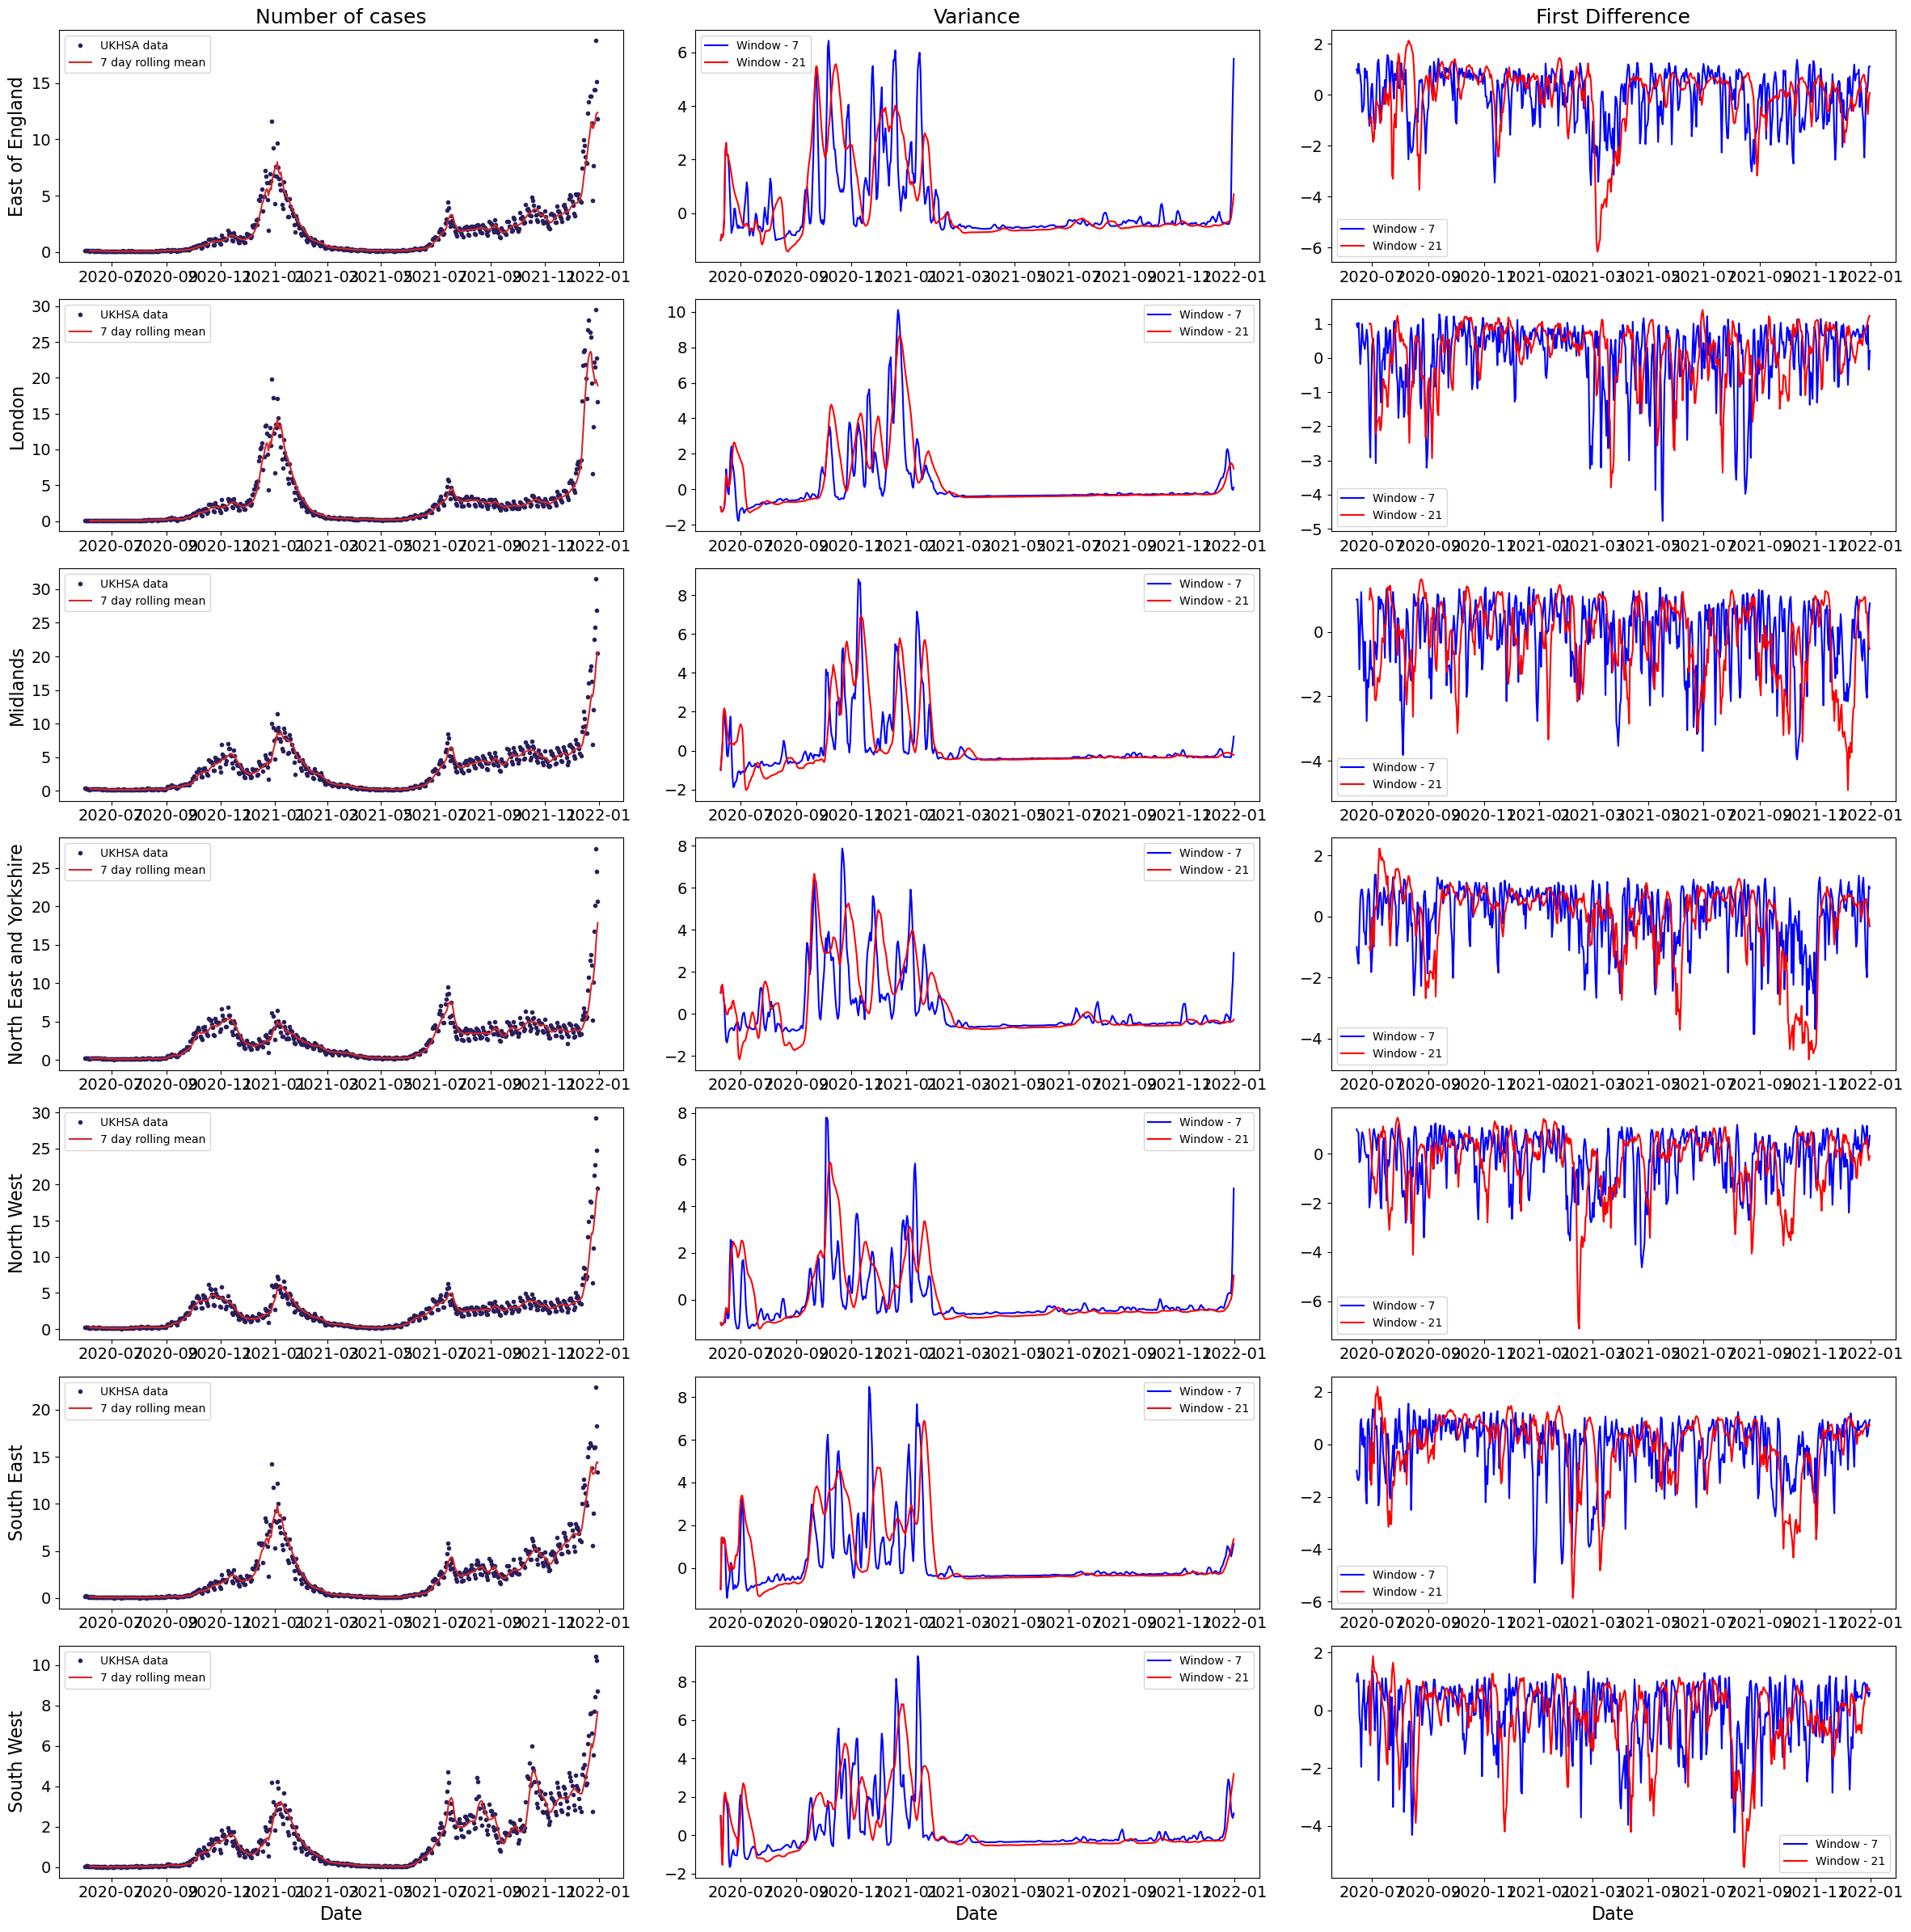

In [24]:
# Plot spatial EWS for each group
regions = np.unique(cases_region['region'].values)
num_regions = len(regions)
fig, axs = plt.subplots(nrows=num_regions,ncols=3,figsize=(24,24))
for row, region in enumerate(regions):
    for col, signal in enumerate(['incidence','variance','acf']):
        counts =  cases_region[cases_region['region']==region].groupby(['date','region']).sum(numeric_only=True)['value'].reset_index()
        counts['rolling'] = counts['value'].rolling(7).mean()
        if signal == 'incidence':
            ax = axs[row, col]
            ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
            ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
            ax.legend(fontsize=16)
            ax.xaxis.label.set_visible(False)
        else:
            ax = axs[row, col]
            signal_data = norm_ews_7total[signal][region].reset_index()
            ax.plot(signal_data['date'],signal_data[region],label='Window - 7',color='blue')
            signal_data = norm_ews_21total[signal][region].reset_index()
            ax.plot(signal_data['date'],signal_data[region],label='Window - 21',color='red')
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.legend()
        if col == 0:
            axs[row,col].set_ylabel(region,fontsize=16)

titles = ['Number of cases','Variance','First Difference']
for i in range(3):
    axs[0,i].set_title(titles[i],fontsize=18)
    axs[len(axs)-1,i].set_xlabel("Date",fontsize=16)
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

plt.tight_layout()
plt.savefig("Figures/normalisedhospitalisationsignals.pdf",dpi=2400,bbox_inches='tight')
plt.show()

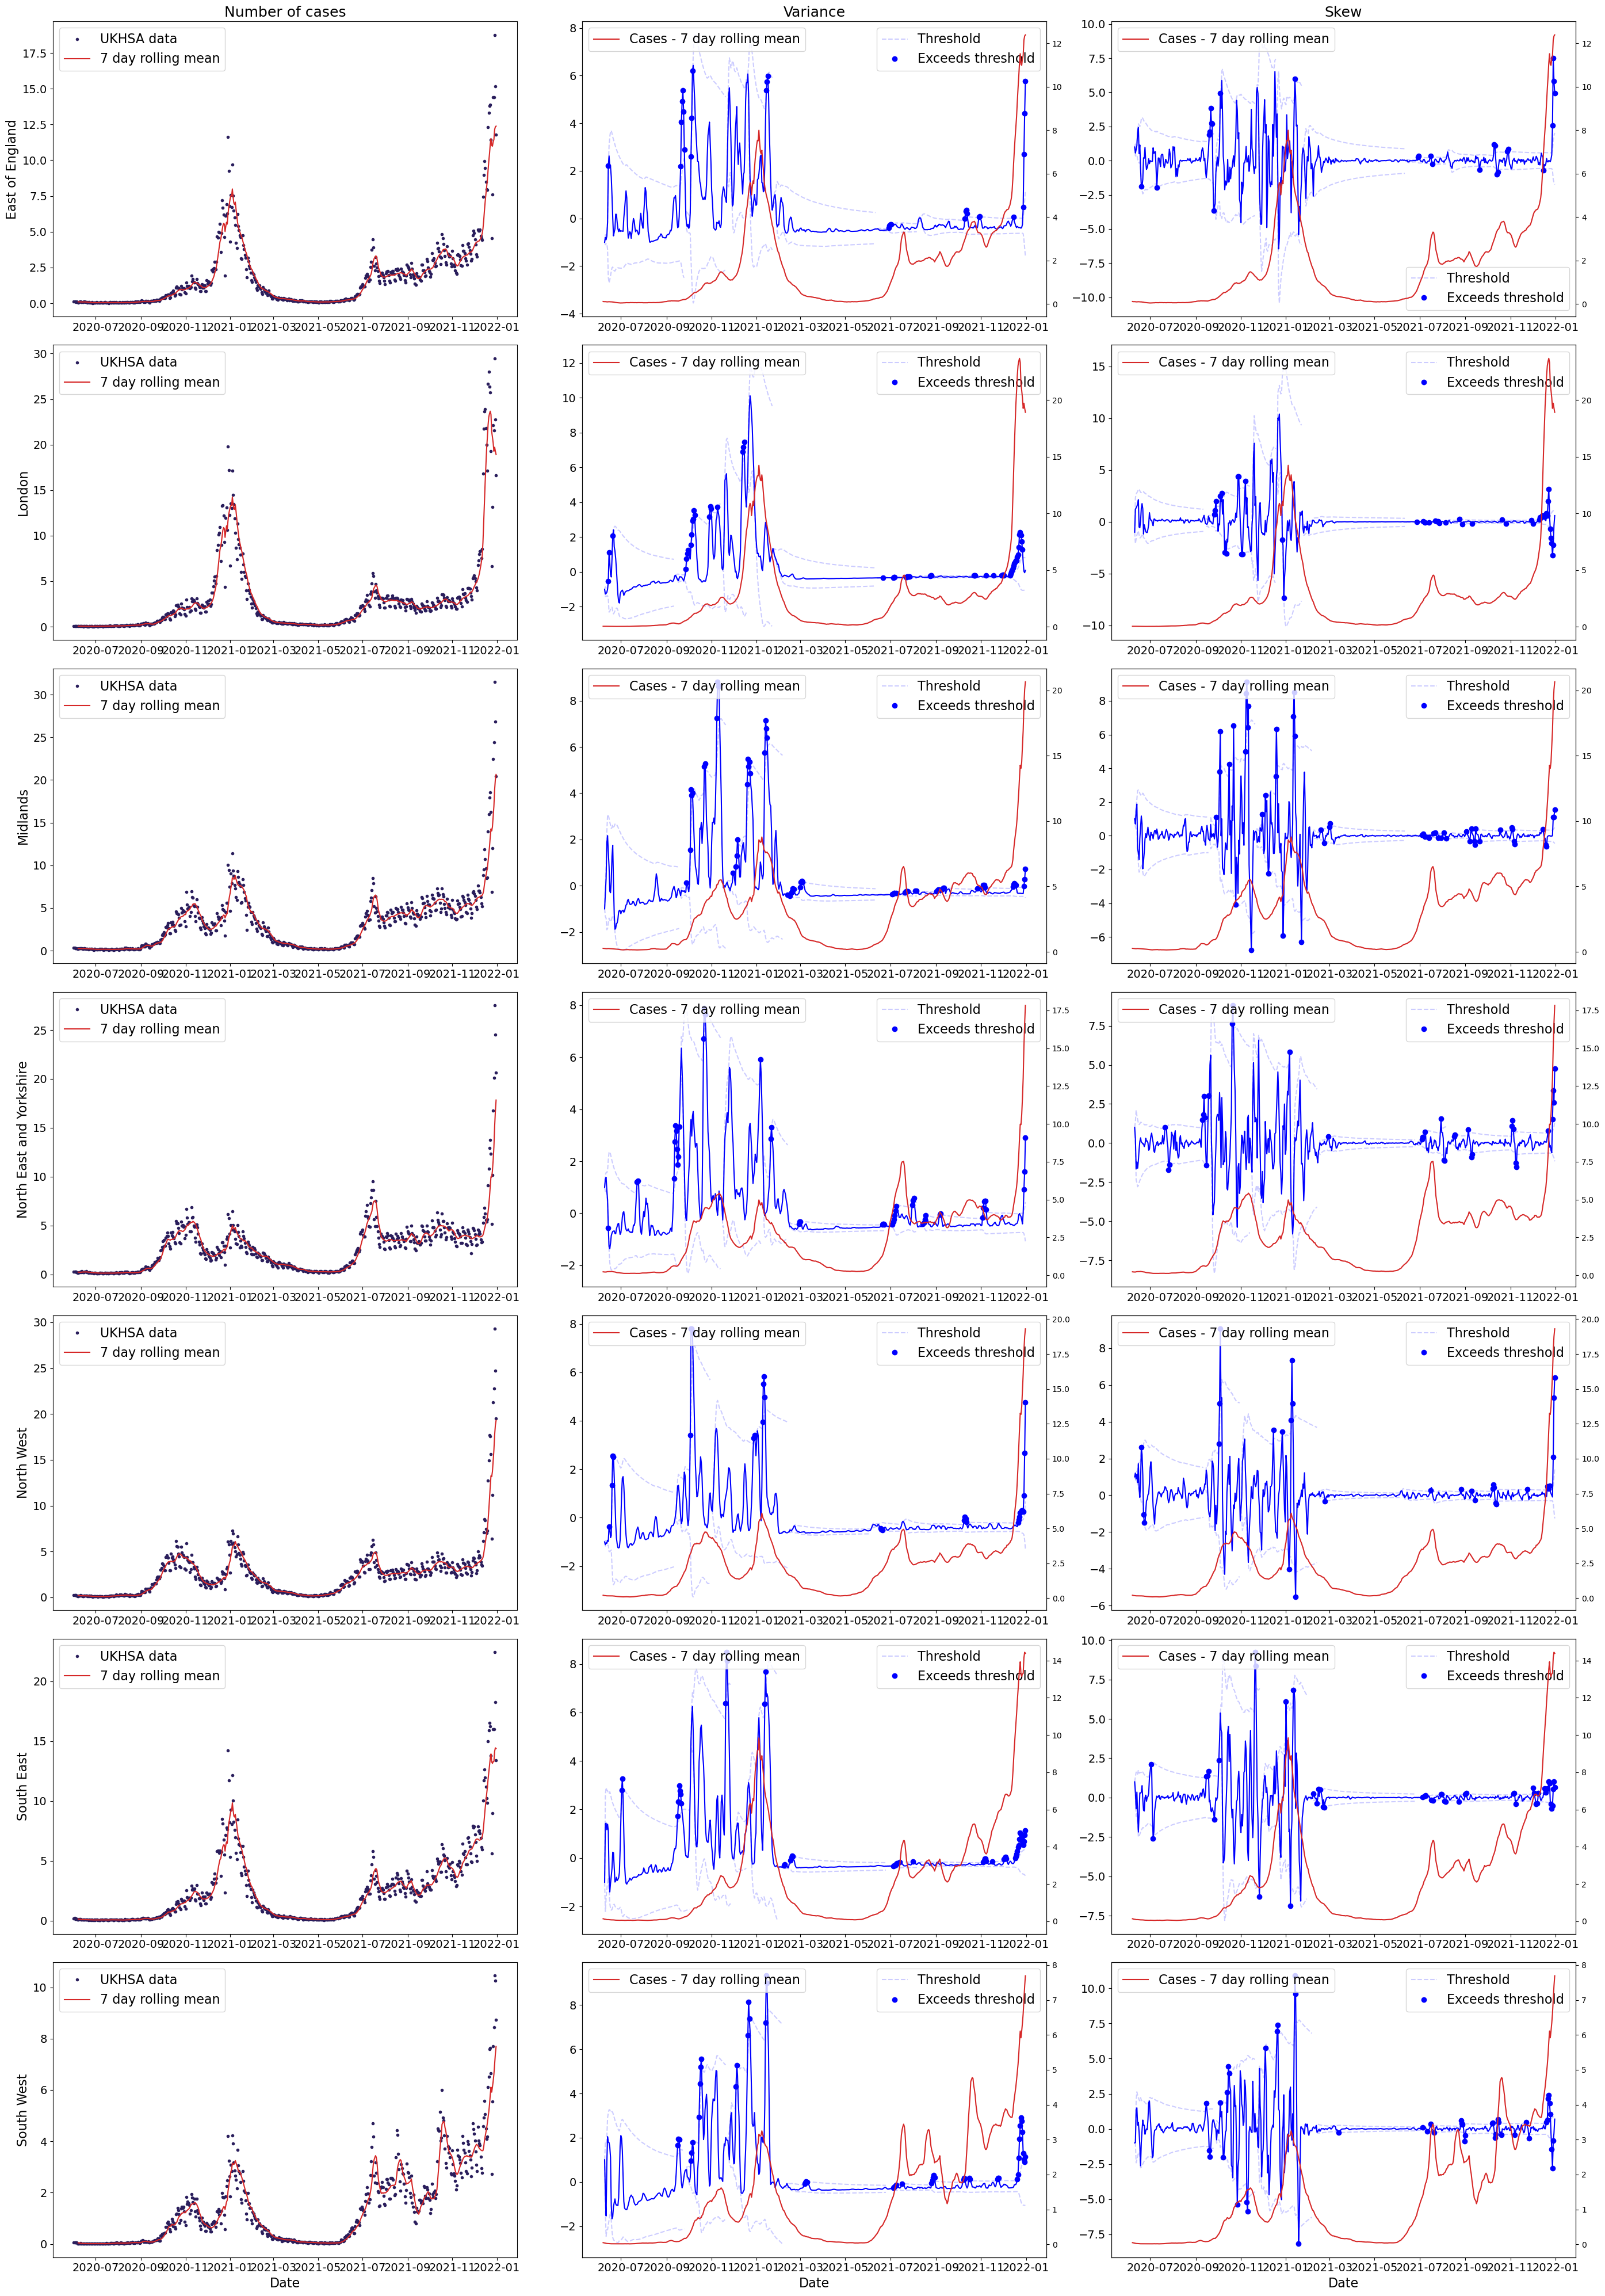

In [19]:
# Plot spatial EWS for each group
regions = np.unique(cases_region['region'].values)
num_regions = len(regions)
fig, axs = plt.subplots(nrows=num_regions,ncols=3,figsize=(28,40))
for row, region in enumerate(regions):
    for col, signal in enumerate(['incidence','variance','first diff']):
        counts =  cases_region[cases_region['region']==region].groupby(['date','region']).sum(numeric_only=True)['value'].reset_index()
        counts['rolling'] = counts['value'].rolling(7).mean()
        if signal == 'incidence':
            ax = axs[row, col]
            ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
            ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
            ax.legend(fontsize=16)
            ax.xaxis.label.set_visible(False)
        else:
            ax = axs[row, col]
            ax2 = ax.twinx()
            ax2.plot(counts['date'],counts['rolling'],color='#D62828',label='Cases - 7 day rolling mean')
            ax2.legend(fontsize=16)
            signal_data = norm_ews_7total[signal][region]
            std_val = std_regional[signal][region]
            mean_val = means_regional[signal][region]
            signal_data = signal_data.reset_index()
            ax.plot(signal_data['date'],signal_data[region],color='blue')
            ax.plot(signal_data['date'],mean_val+2*std_val,color='blue',alpha=0.2,linestyle='--',label='Threshold')
            ax.plot(signal_data['date'],mean_val-2*std_val,color='blue',alpha=0.2,linestyle='--')
            ax.plot(signal_data['date'][indices_regional[signal][region]],signal_data[region][indices_regional[signal][region]],'o',color='blue',label='Exceeds threshold')
            ax.legend(fontsize=16)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        if col == 0:
            axs[row,col].set_ylabel(region,fontsize=16)

titles = ['Number of cases','Variance','Skew']
for i in range(3):
    axs[0,i].set_title(titles[i],fontsize=18)
    axs[len(axs)-1,i].set_xlabel("Date",fontsize=16)
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

plt.tight_layout()
plt.savefig("Figures/hospital2sigma7.pdf",dpi=2400,bbox_inches='tight')
plt.show()

/tmp/ipykernel_97253/3634631483.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_97253/3634631483.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_97253/3634631483.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtyp

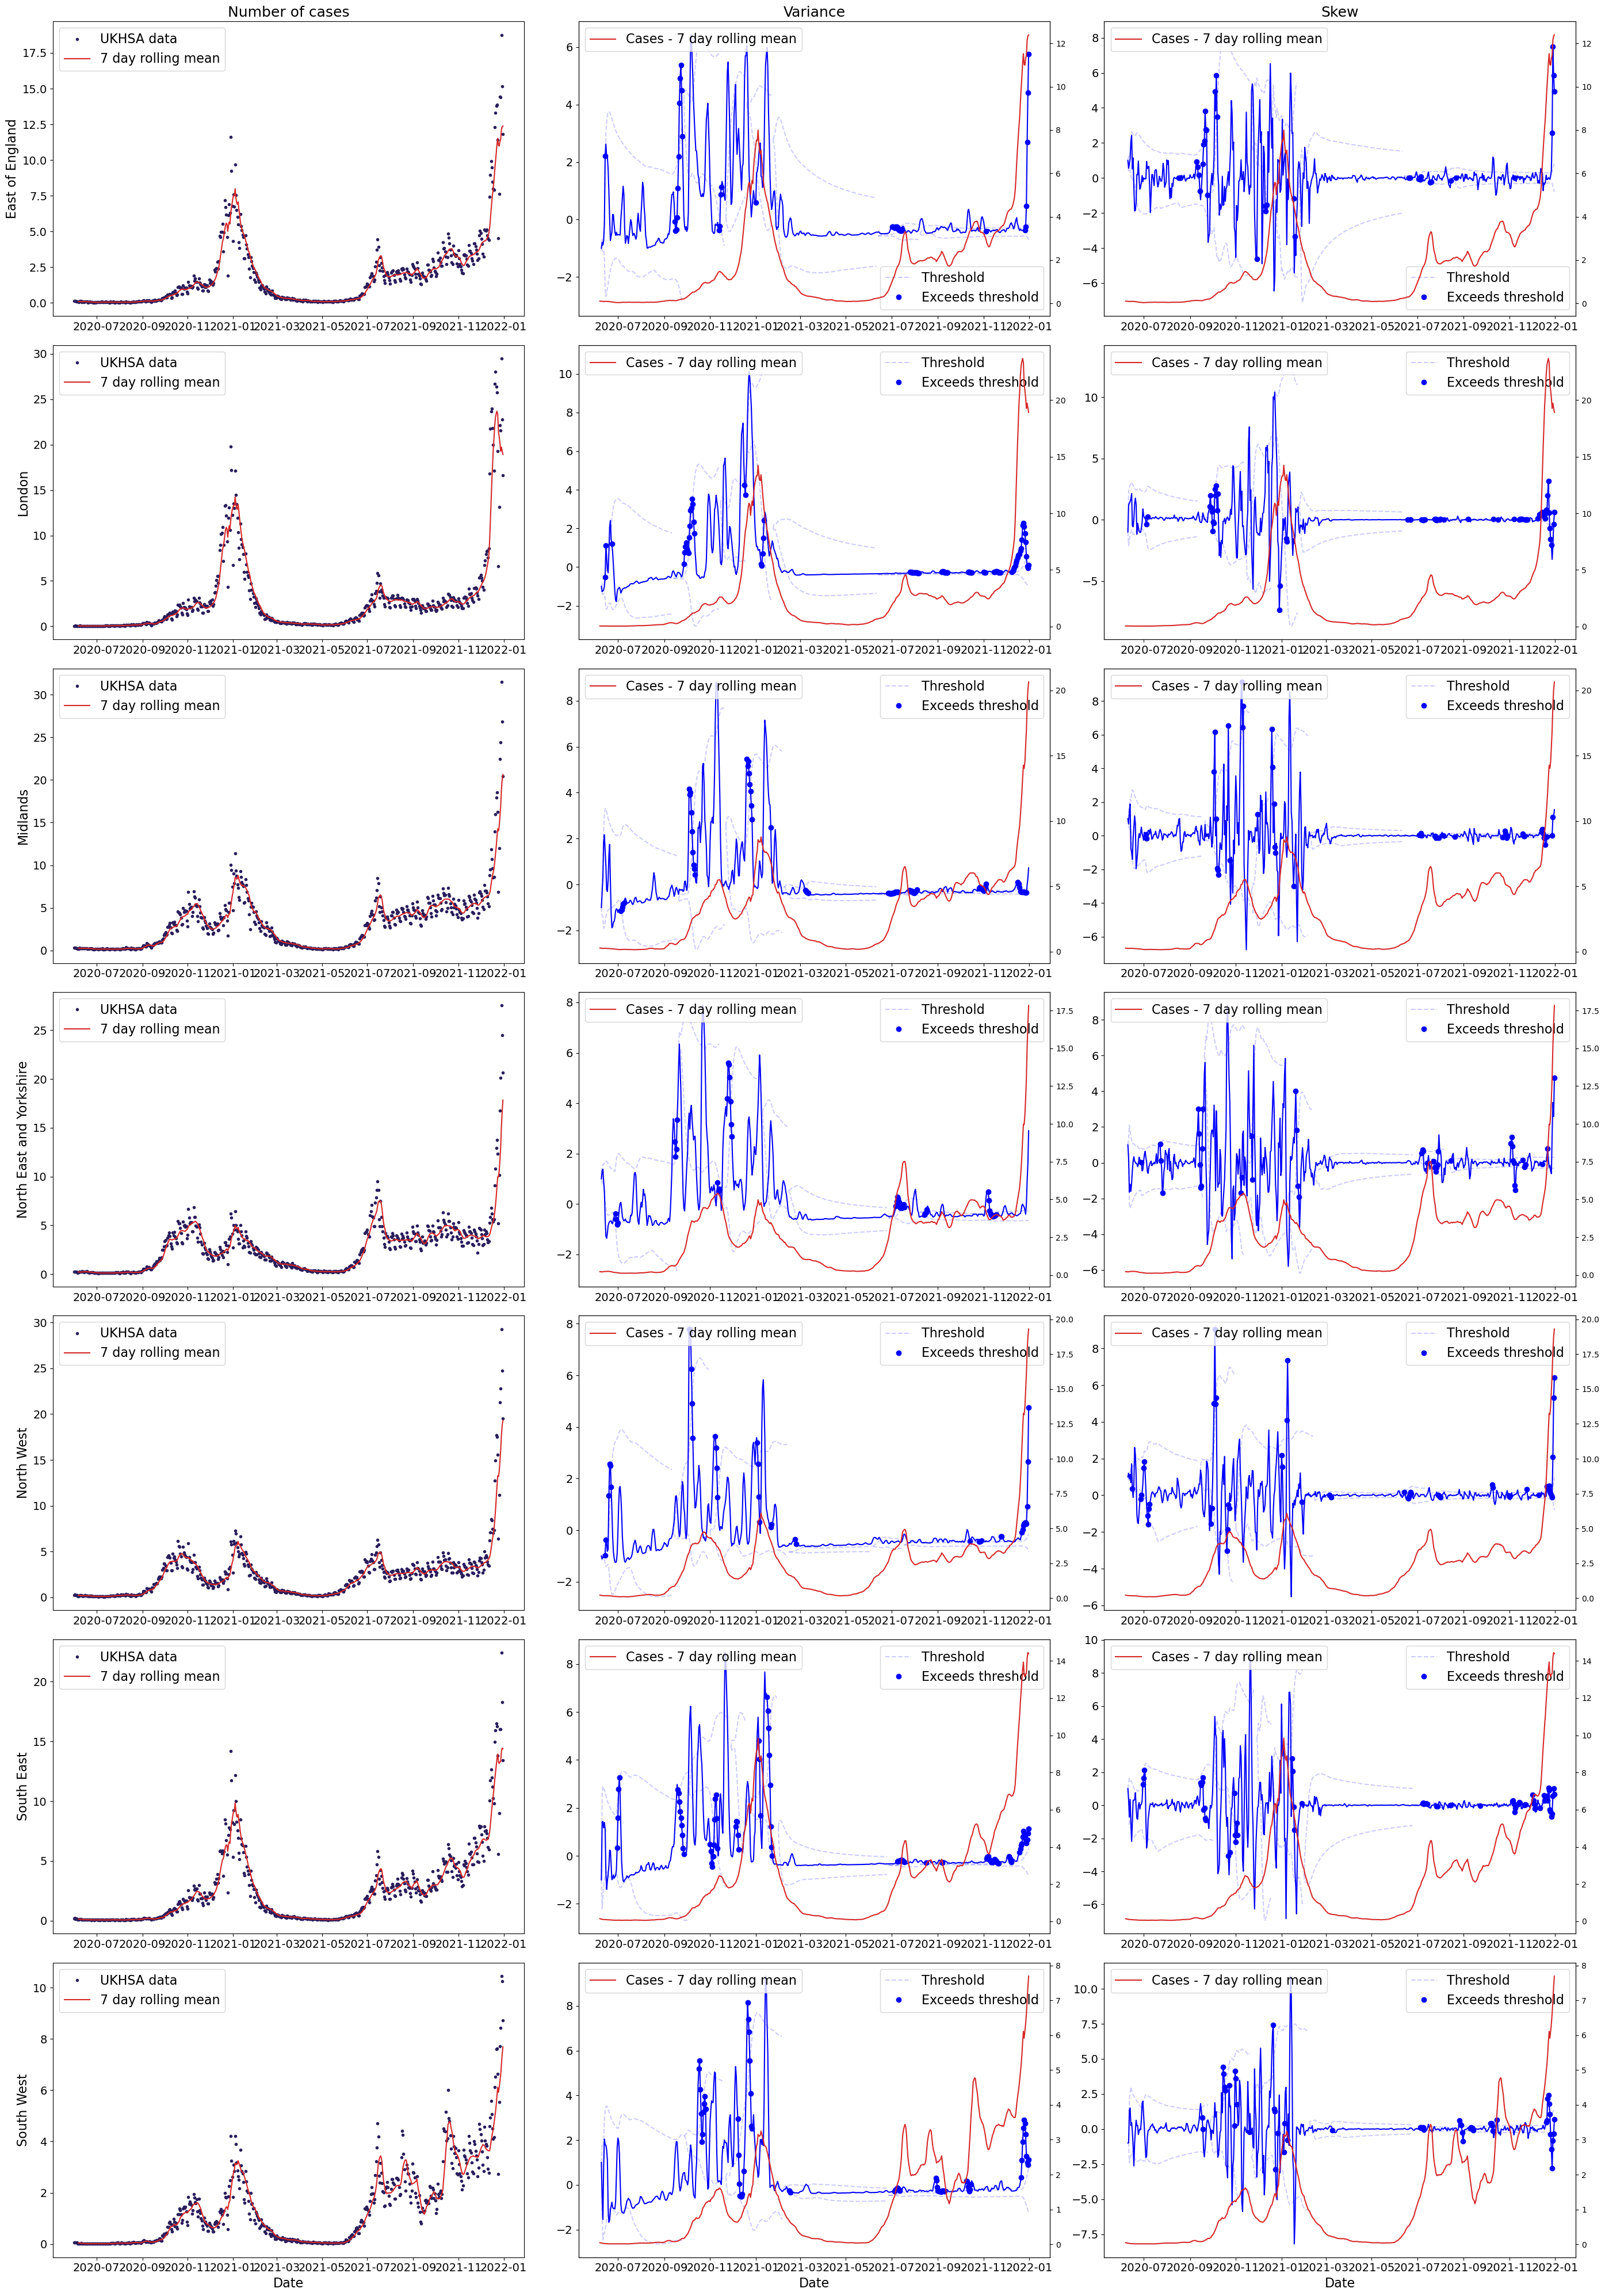

In [20]:
indices_regional, means_regional, std_regional = loop_EWSs_store_results_cutoffs(norm_ews_21total,nhs_transitions)
# Plot spatial EWS for each group
regions = np.unique(cases_region['region'].values)
num_regions = len(regions)
fig, axs = plt.subplots(nrows=num_regions,ncols=3,figsize=(28,40))
for row, region in enumerate(regions):
    for col, signal in enumerate(['incidence','variance','first diff']):
        counts =  cases_region[cases_region['region']==region].groupby(['date','region']).sum(numeric_only=True)['value'].reset_index()
        counts['rolling'] = counts['value'].rolling(7).mean()
        if signal == 'incidence':
            ax = axs[row, col]
            ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
            ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
            ax.legend(fontsize=16)
            ax.xaxis.label.set_visible(False)
        else:
            ax = axs[row, col]
            ax2 = ax.twinx()
            ax2.plot(counts['date'],counts['rolling'],color='#D62828',label='Cases - 7 day rolling mean')
            ax2.legend(fontsize=16)
            signal_data = norm_ews_7total[signal][region]
            std_val = std_regional[signal][region]
            mean_val = means_regional[signal][region]
            signal_data = signal_data.reset_index()
            ax.plot(signal_data['date'],signal_data[region],color='blue')
            ax.plot(signal_data['date'],mean_val+2*std_val,color='blue',alpha=0.2,linestyle='--',label='Threshold')
            ax.plot(signal_data['date'],mean_val-2*std_val,color='blue',alpha=0.2,linestyle='--')
            ax.plot(signal_data['date'][indices_regional[signal][region]],signal_data[region][indices_regional[signal][region]],'o',color='blue',label='Exceeds threshold')
            ax.legend(fontsize=16)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        if col == 0:
            axs[row,col].set_ylabel(region,fontsize=16)

titles = ['Number of cases','Variance','Skew']
for i in range(3):
    axs[0,i].set_title(titles[i],fontsize=18)
    axs[len(axs)-1,i].set_xlabel("Date",fontsize=16)
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

plt.tight_layout()
plt.savefig("Figures/hospital2sigma21.pdf",dpi=2400,bbox_inches='tight')
plt.show()

In [30]:
# Preprocessing hospital data
hospcases21 = pd.read_csv('Data/hospitalCases_nhsRegion_2020.csv')
hospcases20 = pd.read_csv('Data/hospitalCases_nhsRegion_2021.csv')
hospcases21 = hospcases21[['date','area_code','area_name','value']]
hospcases20 = hospcases20[['date','area_code','area_name','value']]
hospcases = pd.concat([hospcases20,hospcases21])
hospcases['date'] = pd.to_datetime(hospcases['date'])
hospcases.set_index('date',inplace=True)
hospcases.sort_index(inplace=True)
hospcases_weekly = hospcases.groupby(['area_code','area_name']).rolling(7).sum().reset_index()

# Add in the NHS populations for normalisation
hospcases_weekly = pd.merge(hospcases_weekly,nhs_pop,left_on='area_name',right_on='region').drop(columns='region')
hospcases_weekly['incidence'] = hospcases_weekly['value'] / hospcases_weekly['population']

# Get the national mean inicidence to spatially detrend
national_mean_total_cases = hospcases_weekly.groupby(['date'])['incidence'].mean().reset_index()
national_mean_total_cases.rename(columns={'incidence': 'national_mean_incidence'}, inplace=True)
hospcases_weekly = pd.merge(hospcases_weekly, national_mean_total_cases, on='date')
hospcases_weekly['detrended'] = hospcases_weekly['incidence'] - hospcases_weekly['national_mean_incidence']
# Convert to wide format for ease of future calculations
wide_data_total_cases = hospcases_weekly.pivot(index='date', columns='area_name', values='detrended')

In [31]:
# Get signals short windows
ews_7total, norm_ews_7total = calculate_ews_rolling(wide_data_total_cases,window_size=7)
ews_14total, norm_ews_14total = calculate_ews_rolling(wide_data_total_cases,window_size=14)
ews_21total, norm_ews_21total = calculate_ews_rolling(wide_data_total_cases,window_size=21)

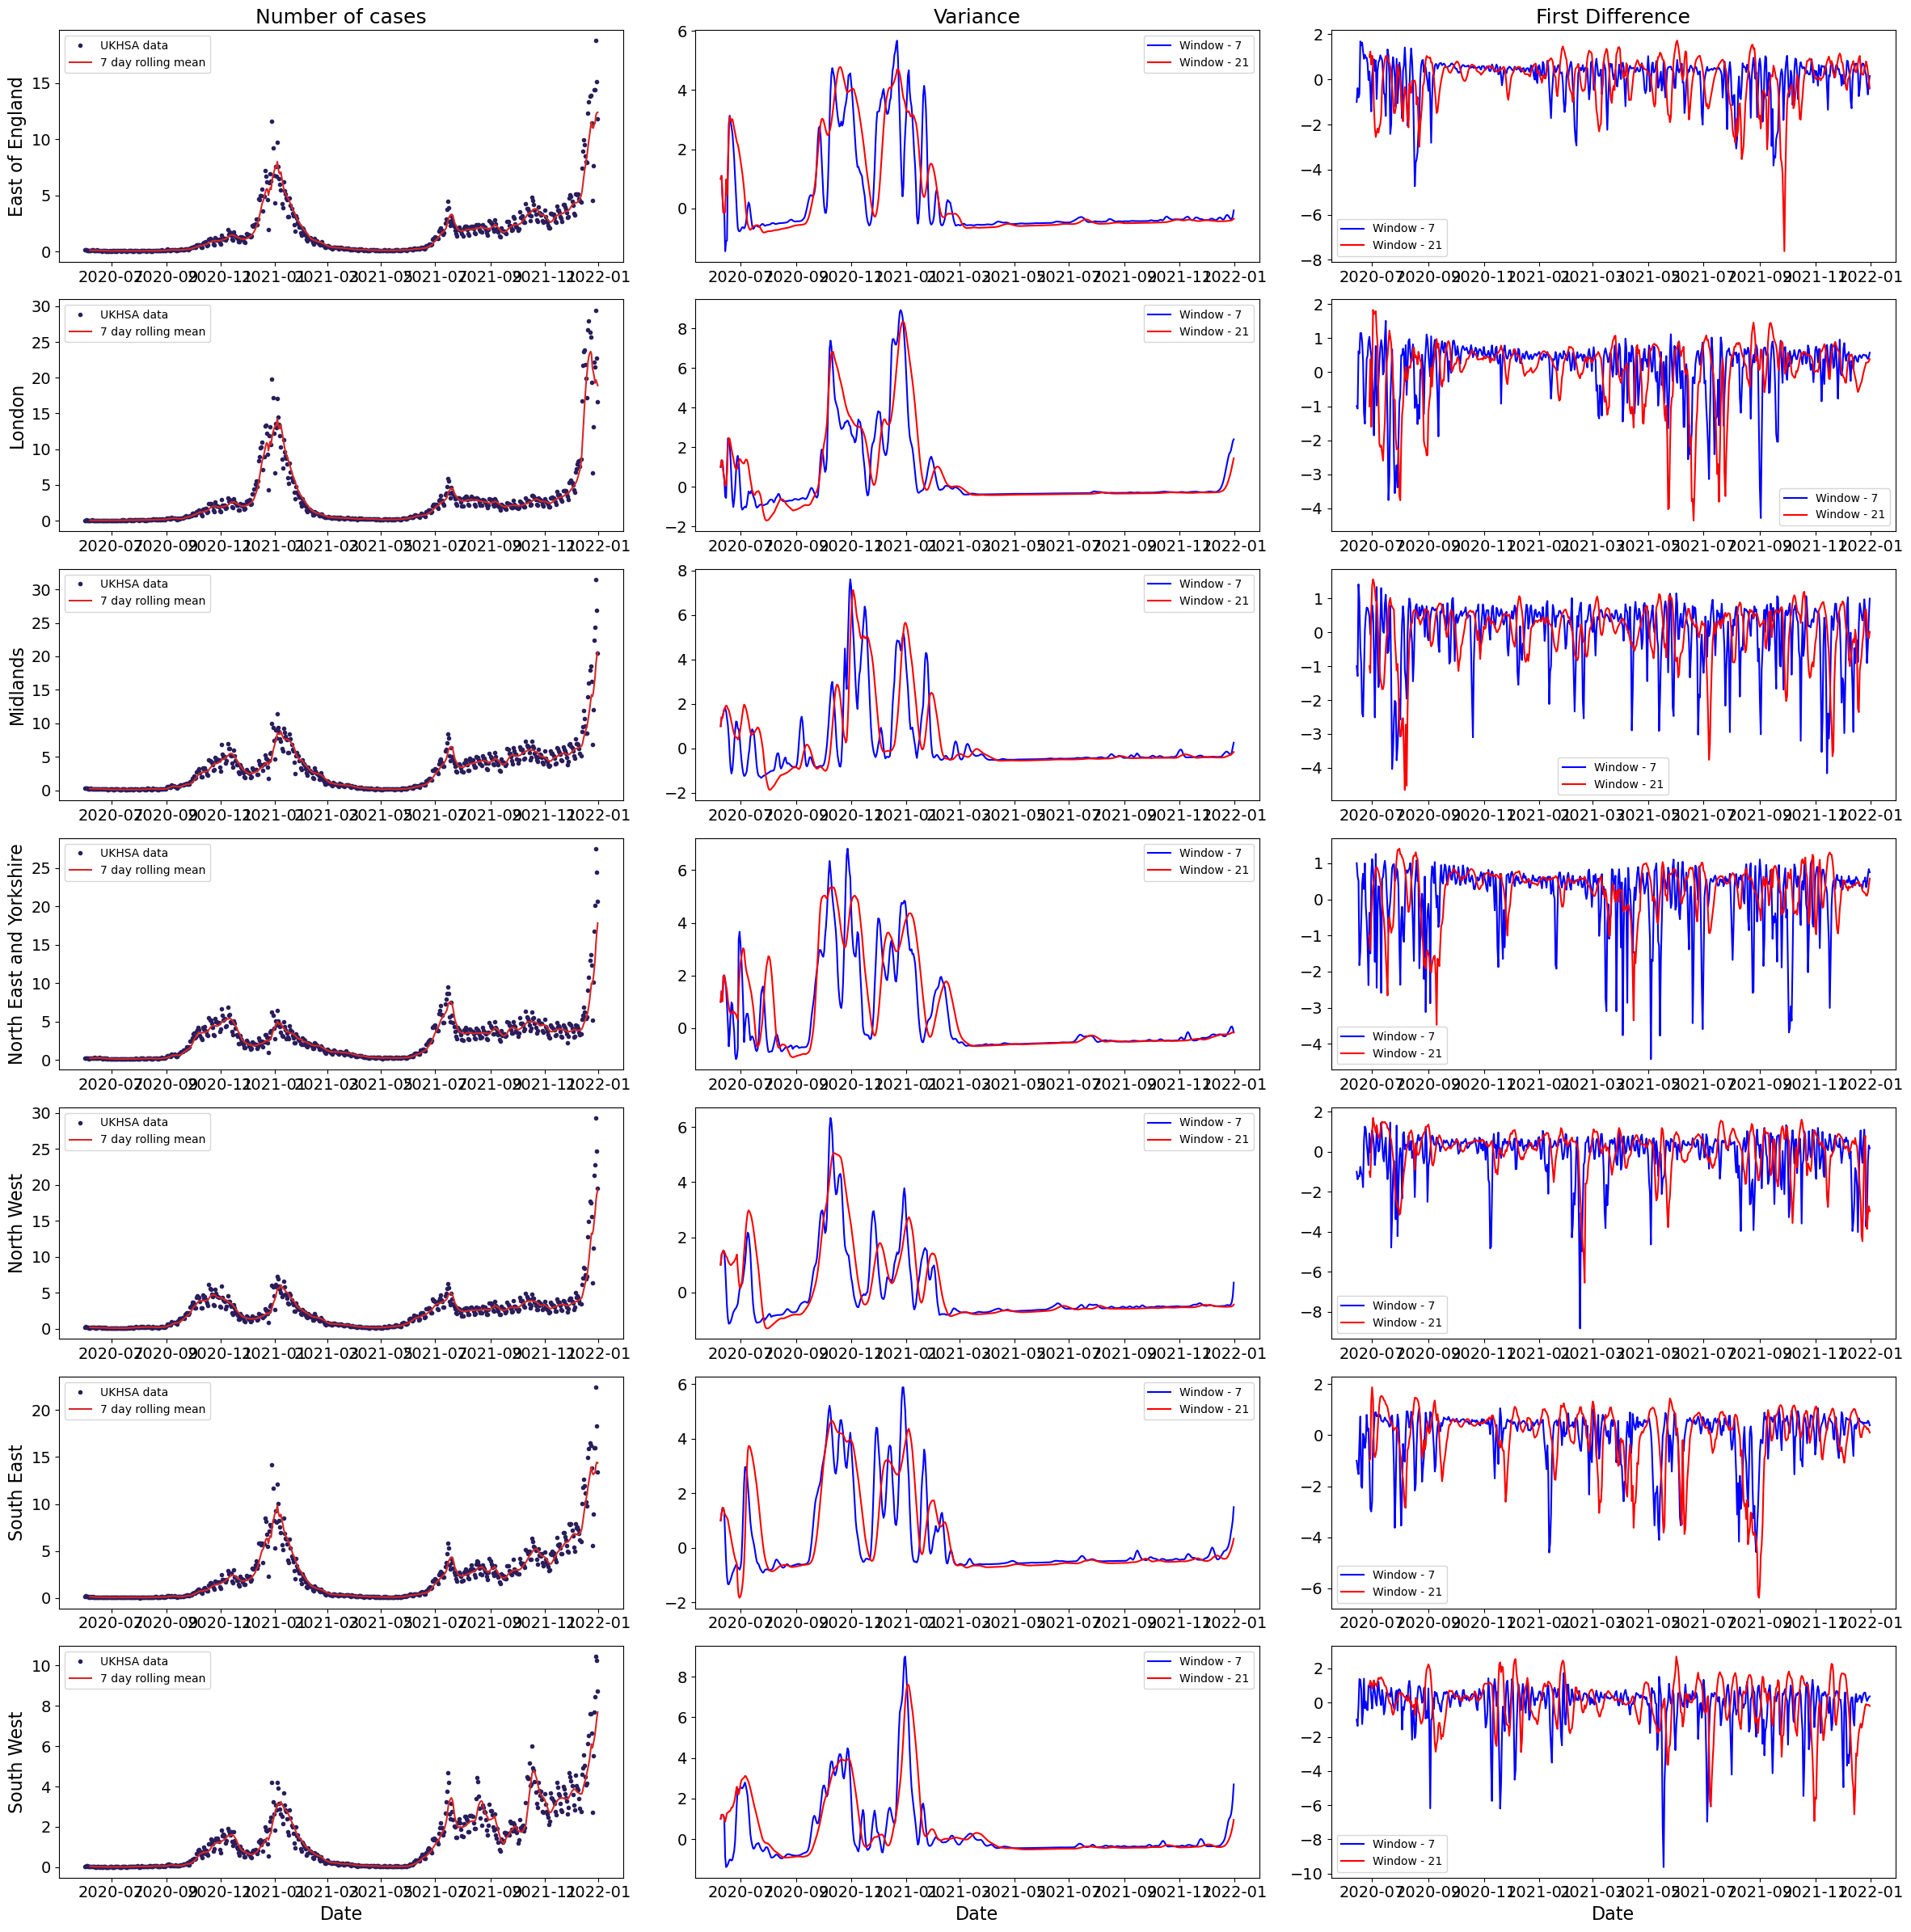

In [32]:
# Plot spatial EWS for each group
regions = np.unique(cases_region['region'].values)
num_regions = len(regions)
fig, axs = plt.subplots(nrows=num_regions,ncols=3,figsize=(24,24))
for row, region in enumerate(regions):
    for col, signal in enumerate(['incidence','variance','acf']):
        counts =  cases_region[cases_region['region']==region].groupby(['date','region']).sum(numeric_only=True)['value'].reset_index()
        counts['rolling'] = counts['value'].rolling(7).mean()
        if signal == 'incidence':
            ax = axs[row, col]
            ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
            ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
            ax.legend(fontsize=16)
            ax.xaxis.label.set_visible(False)
        else:
            ax = axs[row, col]
            signal_data = norm_ews_7total[signal][region].reset_index()
            ax.plot(signal_data['date'],signal_data[region],label='Window - 7',color='blue')
            signal_data = norm_ews_21total[signal][region].reset_index()
            ax.plot(signal_data['date'],signal_data[region],label='Window - 21',color='red')
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.legend()
        if col == 0:
            axs[row,col].set_ylabel(region,fontsize=16)

titles = ['Number of cases','Variance','First Difference']
for i in range(3):
    axs[0,i].set_title(titles[i],fontsize=18)
    axs[len(axs)-1,i].set_xlabel("Date",fontsize=16)
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

plt.tight_layout()
plt.savefig("Figures/normalisedhospcasesignals.pdf",dpi=2400,bbox_inches='tight')
plt.show()

/tmp/ipykernel_97253/3634631483.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_97253/3634631483.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_97253/3634631483.py:6: RuntimeWarning: Mean of empty slice
  running_mean[j] = np.nanmean(standardised[1:j+1])
/home/jlooker/anaconda3/envs/mathsysbase/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtyp

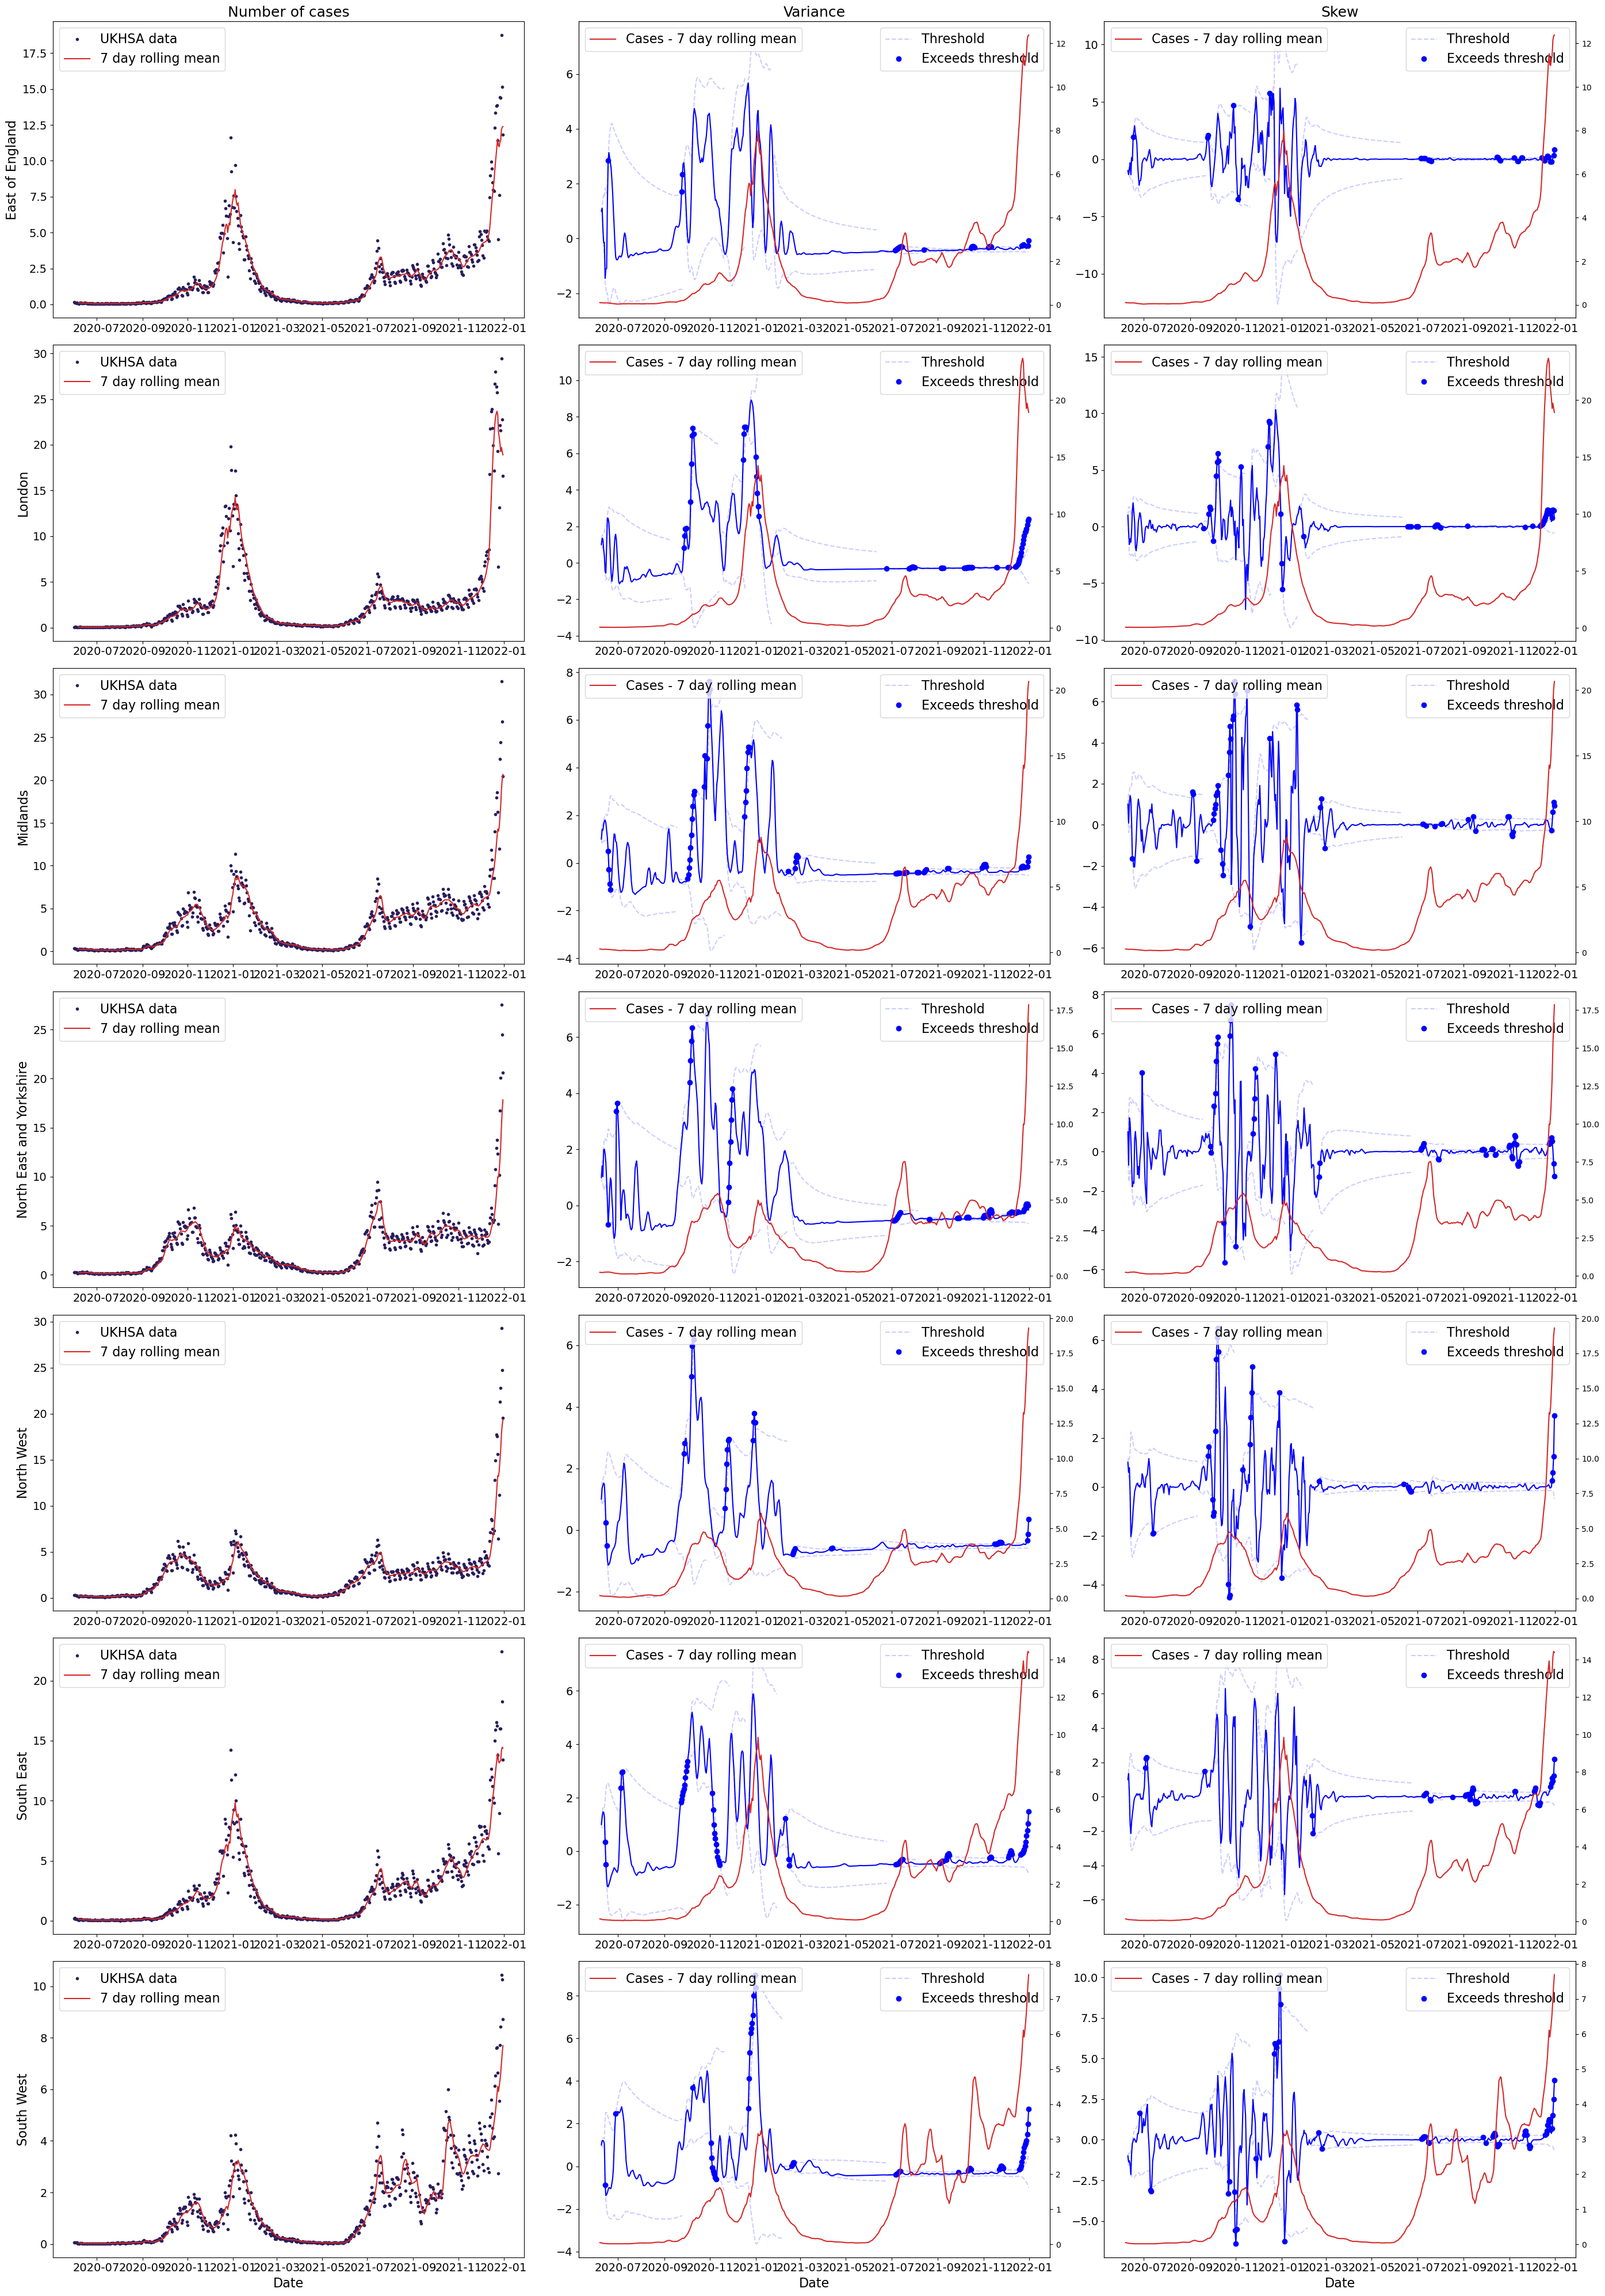

In [34]:
indices_regional, means_regional, std_regional = loop_EWSs_store_results_cutoffs(norm_ews_7total,nhs_transitions)
# Plot spatial EWS for each group
regions = np.unique(cases_region['region'].values)
num_regions = len(regions)
fig, axs = plt.subplots(nrows=num_regions,ncols=3,figsize=(28,40))
for row, region in enumerate(regions):
    for col, signal in enumerate(['incidence','variance','first diff']):
        counts =  cases_region[cases_region['region']==region].groupby(['date','region']).sum(numeric_only=True)['value'].reset_index()
        counts['rolling'] = counts['value'].rolling(7).mean()
        if signal == 'incidence':
            ax = axs[row, col]
            ax.plot(counts['date'],counts['value'],".",label="UKHSA data",color='#2A1E5C')
            ax.plot(counts['date'],counts['rolling'],label="7 day rolling mean",color='#D62828')
            ax.legend(fontsize=16)
            ax.xaxis.label.set_visible(False)
        else:
            ax = axs[row, col]
            ax2 = ax.twinx()
            ax2.plot(counts['date'],counts['rolling'],color='#D62828',label='Cases - 7 day rolling mean')
            ax2.legend(fontsize=16)
            signal_data = norm_ews_7total[signal][region]
            std_val = std_regional[signal][region]
            mean_val = means_regional[signal][region]
            signal_data = signal_data.reset_index()
            ax.plot(signal_data['date'],signal_data[region],color='blue')
            ax.plot(signal_data['date'],mean_val+2*std_val,color='blue',alpha=0.2,linestyle='--',label='Threshold')
            ax.plot(signal_data['date'],mean_val-2*std_val,color='blue',alpha=0.2,linestyle='--')
            ax.plot(signal_data['date'][indices_regional[signal][region]],signal_data[region][indices_regional[signal][region]],'o',color='blue',label='Exceeds threshold')
            ax.legend(fontsize=16)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        if col == 0:
            axs[row,col].set_ylabel(region,fontsize=16)

titles = ['Number of cases','Variance','Skew']
for i in range(3):
    axs[0,i].set_title(titles[i],fontsize=18)
    axs[len(axs)-1,i].set_xlabel("Date",fontsize=16)
    axs[len(axs)-1,i].xaxis.label.set_visible(True)

plt.tight_layout()
plt.savefig("Figures/hospcases2sigma7.pdf",dpi=2400,bbox_inches='tight')
plt.show()